In [2]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans



In [3]:
sys.path.append(os.path.abspath('../scripts'))
from utility import read_csv_file, detect_outliers_iqr, analyze_handsets_data, find_high_correlation_pairs, calculate_decile, get_important_features
from plot import plot_histograms, plot_boxplots, plot_bar_chart, plot_elbow_curve, plot_pie_chart, plot_stacked_bar, plot_correlation_heatmap

Read Preprocessed dataset

In [4]:
data_path = '../data/preprocessed.csv'
telecom_data = read_csv_file(data_path)

In [5]:
telecom_data = telecom_data.get("data")
telecom_data.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Total_Social_Media_Data,Total_Google_Data,Total_Email_Data,Total_Youtube_Data,Total_Netflix_Data,Total_Gaming_Data,Total_Other_Data,Total Duration,Duration Decile,Total DL + UL
0,13114483460844900352,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,208201448079117,33664962239,35521209507511,9.16456699548519E+015,...,1570185.0,2905912.0,3701304.0,18355943.0,17855187.0,292426453.0,180558843.0,2083209.0,9,345629377.0
1,13114483482878900224,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,208201909211140,33681854413,35794009006359,L77566A,...,1933278.0,4414096.0,937385.0,39359124.0,35565545.0,609920783.0,541959383.0,1698167.0,9,707185356.0
2,13114483484080500736,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,208200314458056,33760627129,35281510359387,D42335A,...,1726277.0,10229119.0,3363124.0,34425237.0,23751202.0,229980251.0,414908351.0,1361762.0,9,307690973.0
3,13114483485442799616,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,208201402342131,33750343200,35356610164913,T21824A,...,657493.0,11811761.0,2070983.0,36534765.0,15092588.0,810387875.0,761837216.0,1321509.0,9,889352748.0
4,13114483499480700928,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,208201401415120,33699795932,35407009745539,D88865A,...,912788.0,7748843.0,2110349.0,34222253.0,17539799.0,531237049.0,564619822.0,1089009.0,9,607681403.0


Aggregate Data by User

In [20]:
# Aggregate data by user
user_engagement = telecom_data.groupby('IMSI').agg({
    'Dur. (ms)': 'sum',                # Total session duration
    'Total DL (Bytes)': 'sum',         # Total download traffic
    'Total UL (Bytes)': 'sum',         # Total upload traffic
    'Bearer Id': 'count'               # Session frequency
}).reset_index()

# Rename columns for clarity
user_engagement.rename(columns={
    'Dur. (ms)': 'Total_Duration',
    'Total DL (Bytes)': 'Total_Download',
    'Total UL (Bytes)': 'Total_Upload',
    'Bearer Id': 'Session_Frequency'
}, inplace=True)

# Add Total Traffic
user_engagement['Total_Traffic'] = user_engagement['Total_Download'] + user_engagement['Total_Upload']

# Display the first few rows of the aggregated data
user_engagement.head()


,IMSI,Total_Duration,Total_Download,Total_Upload,Session_Frequency,Total_Traffic
0,204047108489451,869844.0,78697597.0,60456049.0,1,1.391536e+08
1,204080810288647,877385.0,194828056.0,37295915.0,1,2.321240e+08
2,208200101016140,86019.0,31376981.0,53794658.0,1,8.517164e+07
3,208200101127285,86254.0,392918313.0,33583272.0,1,4.265016e+08
4,208200101148045,573923.0,961767023.0,71325004.0,2,1.033092e+09


Select Relevant Features and Normalize

In [21]:
features = user_engagement[['Session_Frequency', 'Total_Duration', 'Total_Traffic']]

# Normalize the features with MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Display the normalized features
pd.DataFrame(scaled_features, columns=features.columns).head()


,Session_Frequency,Total_Duration,Total_Traffic
0,0.0000,0.046515,0.012017
1,0.0000,0.046922,0.022566
2,0.0000,0.004253,0.005892
3,0.0000,0.004266,0.044622
4,0.0625,0.030560,0.113451


 Determine Optimal Number of Clusters (Elbow Method)

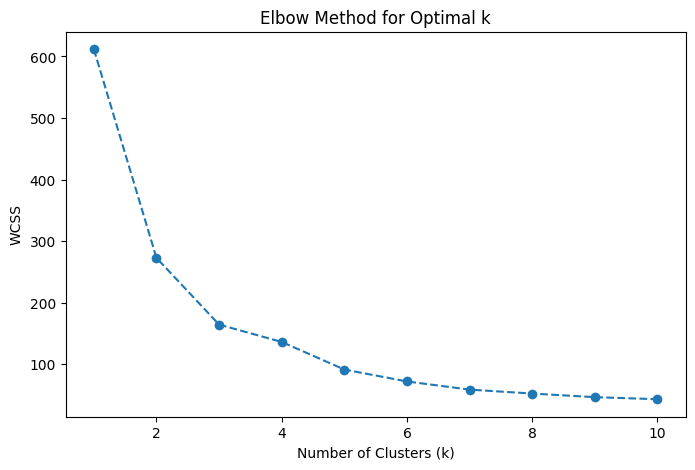

In [22]:
# Elbow method to find optimal k

wcss = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plot_elbow_curve(k_values, wcss)


Perform K-means Clustering

In [26]:
# Choose the optimal k based on the elbow plot
optimal_k = 5  # Adjust based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add cluster labels to the original data
user_engagement['Cluster'] = clusters

# Display the first few rows with cluster labels
user_engagement.head()


,IMSI,Total_Duration,Total_Download,Total_Upload,Session_Frequency,Total_Traffic,Cluster
0,204047108489451,869844.0,78697597.0,60456049.0,1,1.391536e+08,1
1,204080810288647,877385.0,194828056.0,37295915.0,1,2.321240e+08,1
2,208200101016140,86019.0,31376981.0,53794658.0,1,8.517164e+07,1
3,208200101127285,86254.0,392918313.0,33583272.0,1,4.265016e+08,1
4,208200101148045,573923.0,961767023.0,71325004.0,2,1.033092e+09,0


Perform PCA

In [28]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Display the explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)


Explained Variance Ratio: [0.89580587 0.09404061]


Visualize Cluster

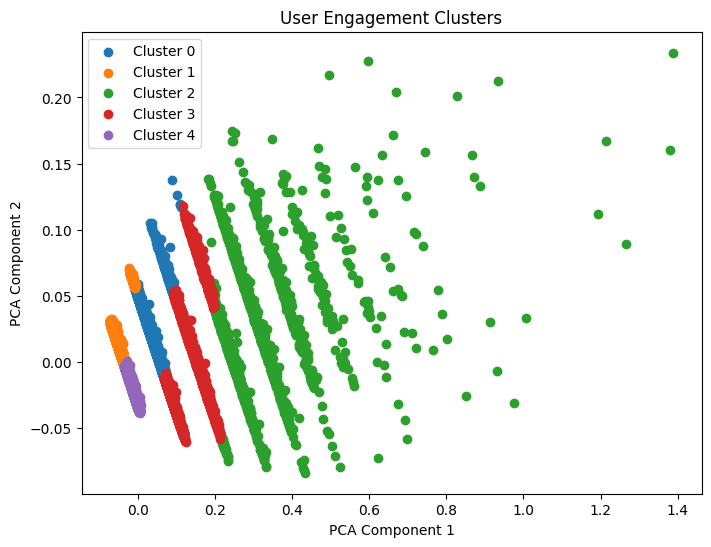

In [29]:
# Plot the clusters
plt.figure(figsize=(8, 6))
for cluster in range(optimal_k):
    cluster_points = pca_features[user_engagement['Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('User Engagement Clusters')
plt.legend()
plt.show()


In [30]:
# Apply KMeans clustering on PCA-transformed data
optimal_k = 5  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
user_engagement['Cluster'] = kmeans.fit_predict(pca_features)

# Count the number of users in each cluster
cluster_counts = user_engagement['Cluster'].value_counts()

# Display the counts
print("Number of users in each cluster:")
print(cluster_counts)


Number of users in each cluster:
Cluster
3    39189
2    38964
0    16232
1     9769
4     2700
Name: count, dtype: int64


Cluster summary

In [31]:
# Compute summary statistics for each cluster
# Analyze the characteristics of each cluster
cluster_summary = user_engagement.groupby('Cluster').mean()
print(cluster_summary)



                 IMSI  Total_Duration  Total_Download  Total_Upload  \
Cluster                                                               
0        2.082016e+14   192654.341178    7.685670e+08  8.368228e+07   
1        2.082017e+14   263163.167673    1.386474e+09  1.034893e+08   
2        2.082014e+14   104287.703675    2.423828e+08  4.129543e+07   
3        2.082017e+14   103615.692694    6.650958e+08  4.136687e+07   
4        2.082016e+14   662214.078148    2.286593e+09  1.939654e+08   

         Session_Frequency  Total_Traffic  
Cluster                                    
0                 2.038566   8.522492e+08  
1                 2.505477   1.489964e+09  
2                 1.010882   2.836782e+08  
3                 1.000000   7.064626e+08  
4                 4.731111   2.480558e+09  


In [32]:
# Aggregate metrics by 'MSISDN/Number' (customer ID)
aggregated_data = telecom_data.groupby('MSISDN/Number').agg(
    session_frequency=('Bearer Id', 'count'),  # Count of sessions by customer
    total_session_duration=('Dur. (ms)', 'sum'),  # Total session duration (in ms)
    total_dl_traffic=('Total DL (Bytes)', 'sum'),  # Total data traffic from DL
    total_ul_traffic=('Total UL (Bytes)', 'sum')   # Total data traffic from UL
).reset_index()

# Add the total traffic by combining 'Total DL (Bytes)' and 'Total UL (Bytes)'
aggregated_data['total_traffic'] = aggregated_data['total_dl_traffic'] + aggregated_data['total_ul_traffic']

# Display the top 10 customers by each metric
top_10_session_frequency = aggregated_data.nlargest(10, 'session_frequency')
top_10_total_session_duration = aggregated_data.nlargest(10, 'total_session_duration')
top_10_total_traffic = aggregated_data.nlargest(10, 'total_traffic')

print("Top 10 customers by session frequency:")
print(top_10_session_frequency)

print("\nTop 10 customers by total session duration:")
print(top_10_total_session_duration)

print("\nTop 10 customers by total traffic:")
print(top_10_total_traffic)





Top 10 customers by session frequency:
       MSISDN/Number  session_frequency  total_session_duration  \
6437     33614892860                 17               9966898.0   
13180    33625779332                 17              18553754.0   
37051    33659725664                 16               4035428.0   
76362    33675877202                 15               4865947.0   
92922    33760536639                 15               9279434.0   
65117    33667163239                 13               8744914.0   
666      33603127838                 12               6287761.0   
1279     33604515716                 12               5207990.0   
13993    33627080969                 12               4703516.0   
92576    33760413819                 12               5321667.0   

       total_dl_traffic  total_ul_traffic  total_traffic  
6437       8.156743e+09       689483001.0   8.846226e+09  
13180      7.770043e+09       729577380.0   8.499621e+09  
37051      7.081602e+09       624260321.0   7.

/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[x_col], y=data[y_col], palette=color_palette)


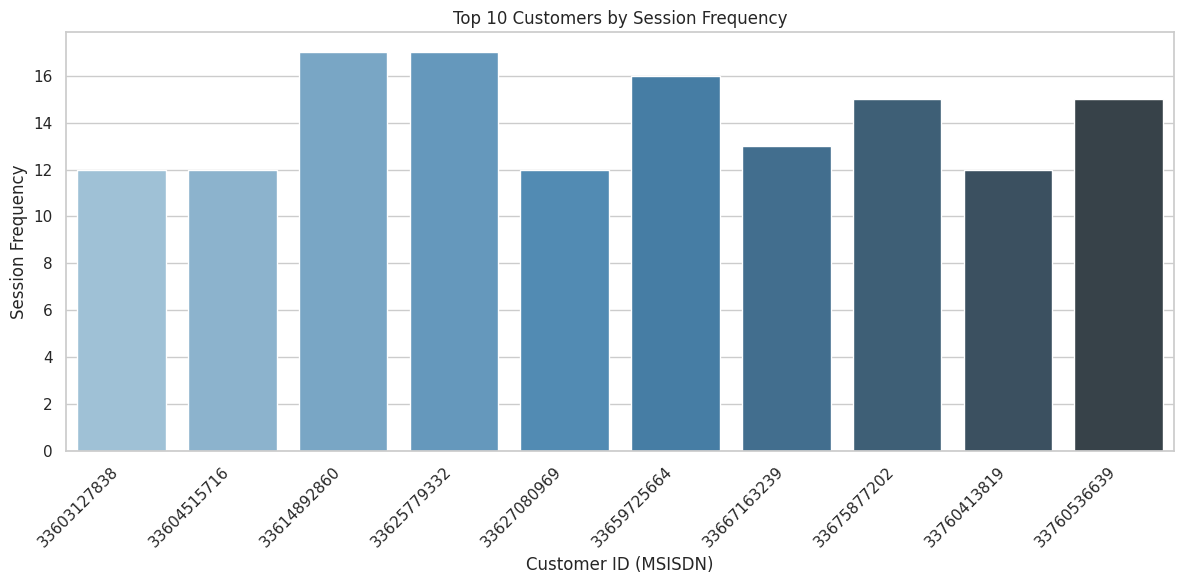

/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[x_col], y=data[y_col], palette=color_palette)


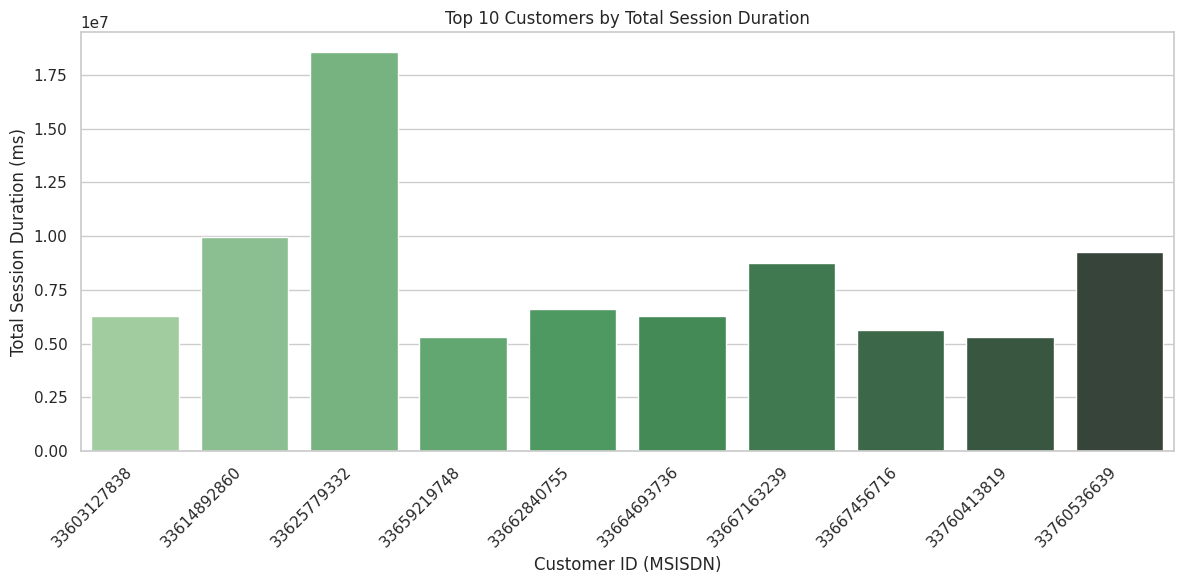

/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[x_col], y=data[y_col], palette=color_palette)


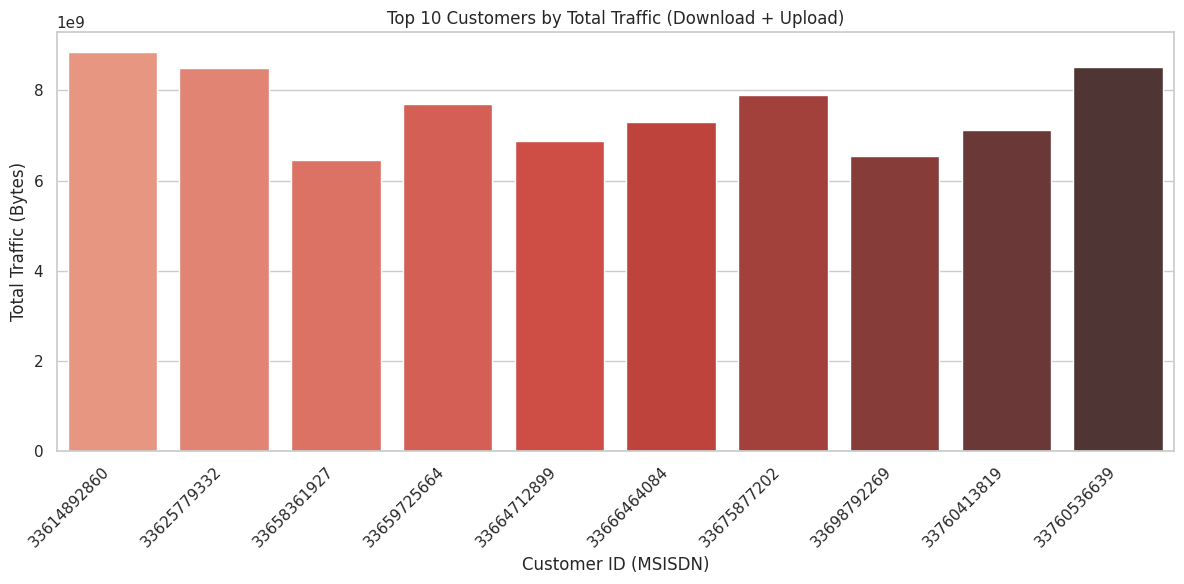

In [57]:
top_10_session_frequency['MSISDN/Number'] = top_10_session_frequency['MSISDN/Number'].astype(int)


# Set up the visual style
sns.set(style="whitegrid")

# 1. Top 10 customers by session frequency
plot_bar_chart(data=top_10_session_frequency, x_col='MSISDN/Number', y_col='session_frequency', 
               x_label='Customer ID (MSISDN)', y_label='Session Frequency', 
               title='Top 10 Customers by Session Frequency', color_palette='Blues_d')

# 2. Top 10 customers by total session duration
plot_bar_chart(data=top_10_total_session_duration, x_col='MSISDN/Number', y_col='total_session_duration', 
               x_label='Customer ID (MSISDN)', y_label='Total Session Duration (ms)', 
               title='Top 10 Customers by Total Session Duration', color_palette='Greens_d')

# 3. Top 10 customers by total traffic
plot_bar_chart(data=top_10_total_traffic, x_col='MSISDN/Number', y_col='total_traffic', 
               x_label='Customer ID (MSISDN)', y_label='Total Traffic (Bytes)', 
               title='Top 10 Customers by Total Traffic (Download + Upload)', color_palette='Reds_d')


In [35]:
# Applications we are interested
applications = ['Google', 'YouTube', 'Games', 'Netflix', 'Email', 'Social Media', 'Other']

# Initialize an empty DataFrame to store results
aggregated_data = pd.DataFrame()

# Loop over each application and aggregate the data
for app in applications:
    if app == 'Google':
        app_data = telecom_data[['MSISDN/Number', 'Google DL (Bytes)', 'Google UL (Bytes)', 'Start', 'Dur. (ms)']]
    elif app == 'YouTube':
        app_data = telecom_data[['MSISDN/Number', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)', 'Start', 'Dur. (ms)']]
    elif app == 'Games':
        app_data = telecom_data[['MSISDN/Number', 'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 'Start', 'Dur. (ms)']]

    # Aggregate data by MSISDN (customer ID)
    app_aggregated = app_data.groupby('MSISDN/Number').agg(
        session_frequency=('Start', 'count'),
        total_session_duration=('Dur. (ms)', 'sum'),
        total_upload_traffic=('Google UL (Bytes)' if app == 'Google' else 'Youtube UL (Bytes)' if app == 'YouTube' else 'Gaming UL (Bytes)', 'sum'),
        total_download_traffic=('Google DL (Bytes)' if app == 'Google' else 'Youtube DL (Bytes)' if app == 'YouTube' else 'Gaming DL (Bytes)', 'sum')
    ).reset_index()

    # Calculate the total traffic (upload + download)
    app_aggregated['total_traffic'] = app_aggregated['total_upload_traffic'] + app_aggregated['total_download_traffic']
    
    # Add the application name for tracking
    app_aggregated['App_Name'] = app
    
    # Append the aggregated data to the overall DataFrame
    aggregated_data = pd.concat([aggregated_data, app_aggregated])

# View aggregated data
print(aggregated_data.head())


   MSISDN/Number  session_frequency  total_session_duration  \
0    33601001722                  1                116720.0   
1    33601001754                  1                181230.0   
2    33601002511                  1                134969.0   
3    33601007832                  1                 49878.0   
4    33601008617                  2                 37104.0   

   total_upload_traffic  total_download_traffic  total_traffic App_Name  
0             1051882.0               3337123.0      4389005.0   Google  
1             1137166.0               4197697.0      5334863.0   Google  
2               99643.0               3343483.0      3443126.0   Google  
3             3740728.0               5937765.0      9678493.0   Google  
4             4770948.0              13728668.0     18499616.0   Google  


In [36]:
# Aggregating the total traffic per application
app_engagement = aggregated_data.groupby(['App_Name', 'MSISDN/Number']).agg(
    total_traffic=('total_traffic', 'sum'),
    total_session_frequency=('session_frequency', 'sum'),
    total_session_duration=('total_session_duration', 'sum')
).reset_index()

# Sorting and displaying the top 10 most engaged users per application
top_10_google = app_engagement[app_engagement['App_Name'] == 'Google'].sort_values(by='total_traffic', ascending=False).head(10)
print("Top 10 most engaged Google users:")
print(top_10_google)

top_10_youtube = app_engagement[app_engagement['App_Name'] == 'YouTube'].sort_values(by='total_traffic', ascending=False).head(10)
print("Top 10 most engaged YouTube users:")
print(top_10_youtube)

top_10_games = app_engagement[app_engagement['App_Name'] == 'Games'].sort_values(by='total_traffic', ascending=False).head(10)
print("Top 10 most engaged Games users:")
print(top_10_games)


Top 10 most engaged Google users:
       App_Name  MSISDN/Number  total_traffic  total_session_frequency  \
226890   Google    33625779332    142307915.0                       17   
220147   Google    33614892860    127973787.0                       17   
306632   Google    33760536639    123223099.0                       15   
250761   Google    33659725664    116516345.0                       16   
319846   Google    33786323068    110254484.0                       12   
290072   Google    33675877202    109860502.0                       15   
278827   Google    33667163239    105032696.0                       13   
308363   Google    33761268199     97089988.0                       10   
300022   Google    33698756430     91935151.0                       10   
249145   Google    33659359429     91041018.0                       11   

        total_session_duration  
226890              18553754.0  
220147               9966898.0  
306632               9279434.0  
250761             

/tmp/ipykernel_53341/1019937348.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='App_Name', y='total_traffic', data=top_3_apps, palette='viridis')


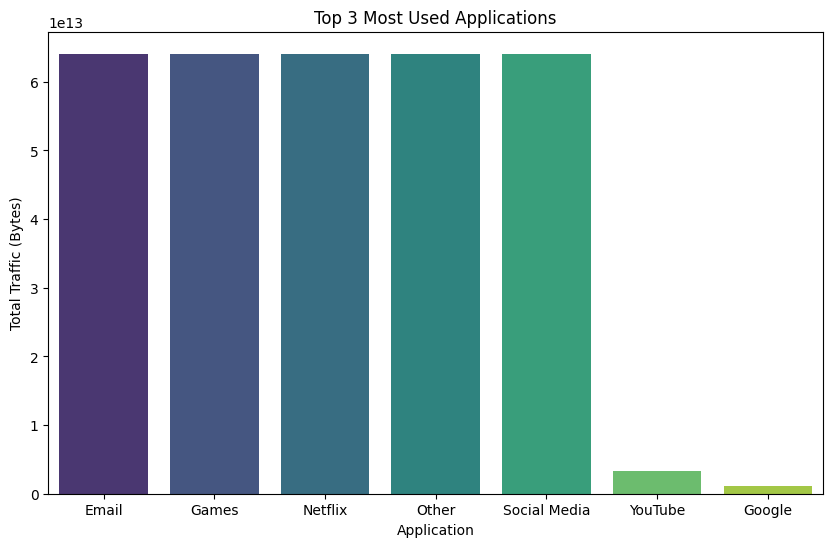

In [38]:
# Aggregating total traffic per application
app_usage = aggregated_data.groupby('App_Name').agg(
    total_traffic=('total_traffic', 'sum')
).reset_index()

# Sorting the applications by total traffic
top_3_apps = app_usage.sort_values(by='total_traffic', ascending=False).head(10)

# Plot the top 3 most used applications
plt.figure(figsize=(10, 6))
sns.barplot(x='App_Name', y='total_traffic', data=top_3_apps, palette='viridis')

plt.title('Top 3 Most Used Applications')
plt.xlabel('Application')
plt.ylabel('Total Traffic (Bytes)')
plt.show()
